In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s6e1/sample_submission.csv
/kaggle/input/playground-series-s6e1/train.csv
/kaggle/input/playground-series-s6e1/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s6e1/train.csv',index_col='id')

In [3]:
train.head()

,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
id,,,,,,,,,,,,
0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0


In [4]:
test = pd.read_csv('/kaggle/input/playground-series-s6e1/test.csv',index_col='id')

In [5]:
test.head()

,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty
id,,,,,,,,,,,
630000,24,other,ba,6.85,65.2,yes,5.2,poor,group study,high,easy
630001,18,male,diploma,6.61,45.0,no,9.3,poor,coaching,low,easy
630002,24,female,b.tech,6.60,98.5,yes,6.2,good,group study,medium,moderate
630003,24,male,diploma,3.03,66.3,yes,5.7,average,mixed,medium,moderate
630004,20,female,b.tech,2.03,42.4,yes,9.2,average,coaching,low,moderate


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 630000 entries, 0 to 629999
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   age               630000 non-null  int64  
 1   gender            630000 non-null  object 
 2   course            630000 non-null  object 
 3   study_hours       630000 non-null  float64
 4   class_attendance  630000 non-null  float64
 5   internet_access   630000 non-null  object 
 6   sleep_hours       630000 non-null  float64
 7   sleep_quality     630000 non-null  object 
 8   study_method      630000 non-null  object 
 9   facility_rating   630000 non-null  object 
 10  exam_difficulty   630000 non-null  object 
 11  exam_score        630000 non-null  float64
dtypes: float64(4), int64(1), object(7)
memory usage: 62.5+ MB


In [7]:
target = train['exam_score']

In [8]:
train = train.drop('exam_score',axis=1)

In [9]:
# finding any null values (training data)

train.isna().sum()

age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
dtype: int64

In [10]:
# finding any null values (testing data)

test.isna().sum()

age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
dtype: int64

In [11]:
# checking the duplicates in the training data
train.duplicated().sum()

np.int64(0)

In [12]:
# checking the duplicates in the testing data
test.duplicated().sum()

np.int64(0)

In [13]:
# identify numeric and cat cols

num_cols = train.select_dtypes(include = ['int64','float64']).columns.to_list()
cat_cols = train.select_dtypes(include = 'object').columns.to_list()

In [14]:
# clipping the outliers

for col in num_cols:
    lower = train[col].quantile(0.01)
    upper = train[col].quantile(0.99)

    train[col] = train[col].clip(lower,upper)
    test[col] = test[col].clip(lower,upper)

In [15]:
# now we will encode categorical data

train_enc = pd.get_dummies(train, columns=cat_cols, drop_first=True)
test_enc = pd.get_dummies(test, columns=cat_cols, drop_first=True)
test_enc = test_enc.reindex(columns=train_enc.columns, fill_value=0)

In [16]:
# Scaling the numeric columns 

from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()

train_enc[num_cols] = scaler.fit_transform(train_enc[num_cols])
test_enc[num_cols] = scaler.fit_transform(test_enc[num_cols]) 

In [17]:
#LR model 

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

N_SPLITS = 5
kf = KFold(n_splits = N_SPLITS, shuffle=True, random_state = 42)

oof_pred = np.zeros(len(train_enc))
oof_pred_test = np.zeros(len(test_enc))

for train_idx,val_idx in kf.split(train_enc,target):
    X_train,X_val = train_enc.iloc[train_idx],train_enc.iloc[val_idx]
    y_train,y_val = target.iloc[train_idx],target.iloc[val_idx]

    model = LinearRegression()
    model.fit(X_train,y_train)
    oof_pred[val_idx] = model.predict(X_val)
    oof_pred_test+= model.predict(test_enc)/N_SPLITS
    

In [18]:
#RMSE through LR

from sklearn.metrics import mean_squared_error

lr_rmse = np.sqrt(mean_squared_error(target,oof_pred))
print(lr_rmse)


8.894822117280297


In [19]:
# Residual 

residual = target-oof_pred

<Axes: >

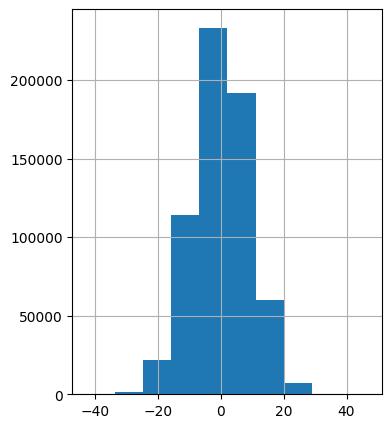

In [20]:
# Residual distribution 

import matplotlib.pyplot as plt
plt.figure(figsize=(4,5))
residual.hist()


In [21]:
X = train_enc
y = residual

In [22]:
X.head()

,age,study_hours,class_attendance,sleep_hours,gender_male,gender_other,course_b.sc,course_b.tech,course_ba,course_bba,...,sleep_quality_good,sleep_quality_poor,study_method_group study,study_method_mixed,study_method_online videos,study_method_self-study,facility_rating_low,facility_rating_medium,exam_difficulty_hard,exam_difficulty_moderate
id,,,,,,,,,,,,,,,,,,,,,
0,0.200943,1.655875,1.538302,-1.245269,False,False,True,False,False,False,...,False,False,False,False,True,False,True,False,False,False
1,-1.126352,0.401573,1.308814,-1.359895,False,True,False,False,False,False,...,False,True,False,False,False,True,False,True,False,True
2,-0.241488,0.287160,1.182595,-0.729454,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,False,True
3,-0.683920,-0.848492,-1.290141,0.703367,True,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,True
4,1.085807,1.545699,0.855575,1.448434,True,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False


In [23]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 630000 entries, 0 to 629999
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   age                         630000 non-null  float64
 1   study_hours                 630000 non-null  float64
 2   class_attendance            630000 non-null  float64
 3   sleep_hours                 630000 non-null  float64
 4   gender_male                 630000 non-null  bool   
 5   gender_other                630000 non-null  bool   
 6   course_b.sc                 630000 non-null  bool   
 7   course_b.tech               630000 non-null  bool   
 8   course_ba                   630000 non-null  bool   
 9   course_bba                  630000 non-null  bool   
 10  course_bca                  630000 non-null  bool   
 11  course_diploma              630000 non-null  bool   
 12  internet_access_yes         630000 non-null  bool   
 13  sleep_quality_good 

In [24]:
from sklearn.model_selection import KFold 
N_SPLITS = 5
kf = KFold(n_splits = N_SPLITS, shuffle= True, random_state = 42)

from lightgbm import LGBMRegressor

params = {
    "n_estimators": 10000,
    "learning_rate": 0.03,
    "max_depth": -1,
    "num_leaves": 31,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42
}

oof_resid_preds = np.zeros(len(X))
oof_resid_preds_test = np.zeros(len(test_enc))

for train_idx, val_idx in kf.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = LGBMRegressor(**params)
    
    model.fit(
        X_train, y_train,
        eval_metric="rmse" 
    )

    oof_resid_preds[val_idx] = model.predict(X_val) 
    oof_resid_preds_test+=model.predict(test_enc)/N_SPLITS


/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 611
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 23
[LightGBM] [Info] Start training from score -0.005022
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 610
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 23
[LightGBM] [Info] Start training from score 0.001395
[LightGBM] [Warning] Found 

In [25]:
from sklearn.metrics import mean_squared_error 
rmse_resid_model = np.sqrt(mean_squared_error(
    residual, oof_resid_preds)) 
print(rmse_resid_model)

8.763445784022688


In [26]:
final_oof = oof_pred + oof_resid_preds 
final_rmse = np.sqrt(mean_squared_error(
    target, final_oof)) 
print("FINAL CV RMSE:", final_rmse) 
final_oof_test = oof_pred_test + oof_resid_preds_test

FINAL CV RMSE: 8.763445784022686


In [27]:
submission = pd.DataFrame({
    'id': test.index,
    'exam_score': final_oof_test
})

submission.to_csv('submission.csv', index=False)